# 非结构网络


非结构网格是没有规则拓扑关系的网格，它通常由多边形三角形组成。
网格中的每个每个元素都可以是二维的多边形或者三维多面体，其中最常见的是二维的三角形以及三维的四面体。
在每个元素之间没有隐含的连通性。

由于结构网格面对复杂几何外形时生成困难，以及耗费大量人工，自动化程度不高等缺点，非结构网格逐渐发展起来.使用它的技术主要有流体分析,空气动力学,有限元分析等细分领域.

matplotlib中有针对它的作图工具`matplotlib.tri`模块


## 核心类`class matplotlib.tri.Triangulation(x, y, triangles=None, mask=None)`

由n个point点和n个三角形组成的非结构化三角形网格。三角形可以由用户指定或使用Delaunay三角测量自动生成。
+ x,y对应网格点的坐标
+ triangles 对于每个三角形，组成三角形的三个点的索引以逆时针方式排序。如果未指定，则计算Delaunay三角剖分。
+ mask 指定哪些三角形的屏蔽数组

它的方法有:

+ calculate_plane_coefficients(z)

    从点（x，y）坐标和指定的z形阵列（n points）计算所有未屏蔽三角形的平面方程系数。返回的数组具有形状（n points，3）并且允许使用
    z = array [tri，0] * x array [tri，1] * y array [tri，2]

+ edges

    返回包含非屏蔽三角形的所有边的整型数组形状（nedges，2）。每个边是起点索引和终点索引。每个边（开始，结束和结束，开始）只出现一次。

+ get_masked_triangles()

    返回未屏蔽的三角形数组。
    
+ get_trifinder()

    返回此三角剖分的默认matplotlib.tri.TriFinder,如果需要,创建它.这允许轻松共享相同的TriFinder对象。

+ neighbors
    
    邻点

+ set_mask(mask)
    
    设置或清除屏蔽数组.

## 寻找是三角形算法

`matplotlib.tri.TriFinder(triangulation)`
TriFinder类使用来自M.de Berg，M.van Kreveld，M.Overmars和O. Schwarzkopf的书“Computational Geometry，Algorithms and Applications”，第二版中的梯形映射算法来实现。三角测量必须有效，即它不能具有重复的点，由共线点形成的三角形或重叠的三角形。该算法对于由共线点形成的三角形具有一些公差，但是这不应被依赖。
这个类的实例可以被调用 `trifinder(x,y)`,调用后会
返回包含指定x，y点所在的三角形的索引的数组，或者对于不在三角形内的点返回-1。
x，y是相同形状和任意数量维度的类阵列x和y坐标。
返回具有相同形状和x和y的整数数组。

## 三角形网格线性插值

`matplotlib.tri.LinearTriInterpolator(triangulation, z, trifinder=None)`

LinearTriInterpolator对三角形网格执行线性插值。每个三角形由平面表示，使得点（x，y）处的内插值位于包含（x，y）的三角形的平面上。因此，内插值在三角形上是连续的，但是它们的一阶导数在三角形之间的边缘处是不连续的。

他的实例有方法`gradient(x, y)`,可以返回在指定的x，y点包含插值导数的2个包含屏蔽数组的列表。

而实例被调用会返回在指定的x，y点包含插值的屏蔽数组。

## 三角形网格执行三次插值

`matplotlib.tri.CubicTriInterpolator(triangulation, z, kind='min_E', trifinder=None, dz=None)`

CubicTriInterpolator对三角形网格执行三次插值。在一维, 一段上 做三次插值,函数由函数的值和其两端的导数定义。这在三角形内的2-d中几乎相同，除了函数的值及其2导数必须在每个三角形节点处定义。CubicTriInterpolator获取每个节点（由用户提供）的函数值，并在内部计算导数的值，从而实现平滑插值。 （作为一个特殊功能，用户还可以在每个节点强加导数的值，但这不应该是常见的用法。）

+ kind

    选择平滑算法，以便计算内插导数（默认为“min_E”）：如果'min_E'：（默认）计算每个节点处的导数以最小化弯曲能量。如果'geom'：每个节点的导数被计算为相关三角形法线的加权平均值。用于速度优化（大网格）。如果'user'：用户提供参数dz，因此不需要计算。
    
+ trifinder
    
    如果未指定，Triangulation的默认TriFinder将通过调用matplotlib.tri.Triangulation.get_trifinder（）来使用。
    
+ dz

    仅在kind ='user'时使用。在这种情况下，dz必须提供为（dzdx，dzdy），其中dzdx，dzdy是与z相同形状的数组，并且是三角点处的内插一阶导数。
    
    
内插基于三角网格的Clough-Tocher细分方案（为了使其更清楚，网格的每个三角形将被划分为3个子三角形，并且在每个子三角形上，内插函数是2的三次多项式坐标）。这种技术源自FEM（有限元方法）分析;使用的元件是还原的Hsieh-Clough-Tocher（HCT）元件。其形状函数在[R1]中描述。组合函数保证是C1平滑的，即它是连续的，并且其一阶导数也是连续的（这在三角形内容中是容易显示的，但当穿过边缘时也是如此）。

在默认情况下（种类='min_E'），内插器使由HCT元素形状函数生成的函数空间上的曲率能量最小化 - 利用施加的值，但在每个节点处的任意导数。最小化的函数是所谓的总曲率的积分（基于来自[R2] -PCG稀疏求解器的算法的实现）：


$ E(z) = {\frac 1 2 } \int_\Omega ((\frac {\partial^2 z} {\partial x^2} )^2 + (\frac {\partial^2 z} {\partial y^2} )^2 +2(\frac {\partial^2 z} {\partial y \partial x} )^2)dxdy $


如果用户选择case type ='geom'，则使用简单的几何近似（三角形法线向量的加权平均），这可以在非常大的网格上提高速度。

例子:

In [1]:
from matplotlib.tri import Triangulation, UniformTriRefiner,\
    CubicTriInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math

In [3]:
# 计算偶极子的电位
def dipole_potential(x, y):
    """ The electric dipole potential V """
    r_sq = x**2 + y**2
    theta = np.arctan2(y, x)
    z = np.cos(theta)/r_sq
    return (np.max(z) - z) / (np.max(z) - np.min(z))

In [4]:
# 创建三角网格
#-----------------------------------------------------------------------------
# 首先创建点的x和y坐标

n_angles = 30
n_radii = 10
min_radius = 0.2
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2*math.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += math.pi/n_angles

x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
V = dipole_potential(x, y)

In [8]:
V[:5]

array([ 0.        ,  0.25222984,  0.35123967,  0.40177562,  0.4296875 ])

In [9]:
triang = Triangulation(x, y)

In [12]:
# 屏蔽掉不需要的值
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = np.where(xmid*xmid + ymid*ymid < min_radius*min_radius, 1, 0)
triang.set_mask(mask)

In [13]:
# 精细化数据 - 内插电位V

refiner = UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(V, subdiv=3)

In [15]:
# 计算电场（Ex，Ey）作为电位梯度
tci = CubicTriInterpolator(triang, -V)

In [16]:
# 这里,gradient()需要 网格节点，但可以在其他任何地方
(Ex, Ey) = tci.gradient(triang.x, triang.y)
E_norm = np.sqrt(Ex**2 + Ey**2)

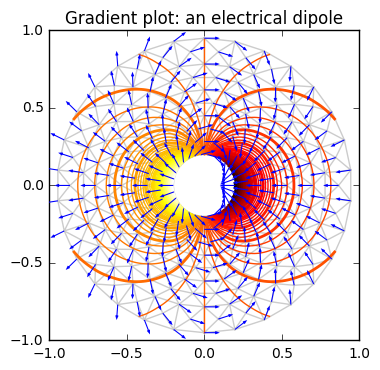

In [18]:
#作图
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, color='0.8')

levels = np.arange(0., 1., 0.01)
cmap = cm.get_cmap(name='hot', lut=None)
# 三角等高线
plt.tricontour(tri_refi, z_test_refi, levels=levels, cmap=cmap,
               linewidths=[2.0, 1.0, 1.0, 1.0])
# 用quiver绘制电矢量场的方向
plt.quiver(triang.x, triang.y, Ex/E_norm, Ey/E_norm,
           units='xy', scale=10., zorder=3, color='blue',
           width=0.007, headwidth=3., headlength=4.)

plt.title('Gradient plot: an electrical dipole')
plt.show()


## 通过递归细分的均匀网格细化

`matplotlib.tri.UniformTriRefiner(triangulation)`类

通过递归细分的均匀网格细化。

它有方法

+ `refine_field(z, triinterpolator=None, subdiv=3)`
    用来优化在封装三角定义上定义的字段

    + triinterpolator插值器用于场插值。如果未指定，将使用CubicTriInterpolator。
    + subdiv细分的递归级别。默认为3.每个三角形将被划分为4个**子细分三角形。

+ `refine_triangulation(return_tri_index=False, subdiv=3)`

    计算封装三角测量的均匀精细三角测量refi_triangulation。此函数通过将每个父三角形递归地（递归细分的水平）分割成在边中间节点上构建的4个子子三角形，来细化封装的三角形。最后，每个三角形因此被划分为4 **个子三角形。 subdiv的默认值为3，从而为初始三角形的每个三角形产生64个精细子三角形。
    
    + return_tri_index布尔值，指示是否将返回指示每个点的父三角形索引的索引表。默认值False。

例子:在粗糙的三角形网格（例如，由相对稀疏的测试数据构建的三角测量）上绘制高质量等高线：

In [19]:
# 在用户定义的三角网格上演示高分辨率三轴定位用matplotlib.tri.UniformTriRefiner

import matplotlib.tri as tri

In [20]:
# 要分析测试的function
def function_z(x, y):
    """ A function of 2 variables """
    r1 = np.sqrt((0.5 - x)**2 + (0.5 - y)**2)
    theta1 = np.arctan2(0.5 - x, 0.5 - y)
    r2 = np.sqrt((-x - 0.2)**2 + (-y - 0.2)**2)
    theta2 = np.arctan2(-x - 0.2, -y - 0.2)
    z = -(2*(np.exp((r1/10)**2) - 1)*30. * np.cos(7.*theta1) +
          (np.exp((r2/10)**2) - 1)*30. * np.cos(11.*theta2) +
          0.7*(x**2 + y**2))
    return (np.max(z) - z)/(np.max(z) - np.min(z))

In [21]:
# 构建三角网络中的点

n_angles = 20
n_radii = 10
min_radius = 0.15
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2*math.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += math.pi/n_angles

x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
z = function_z(x, y)

In [22]:
#开始构建三角网络
triang = tri.Triangulation(x, y)

# 屏蔽不要的店
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = np.where(xmid*xmid + ymid*ymid < min_radius*min_radius, 1, 0)
triang.set_mask(mask)

In [23]:
# 精细化数据 
refiner = tri.UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(z, subdiv=3)


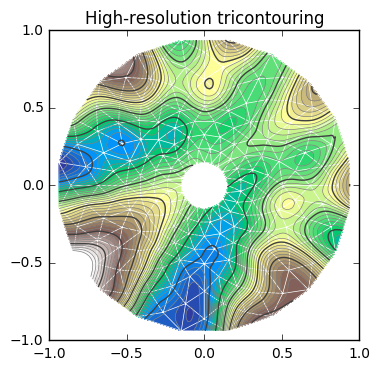

In [24]:
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(triang, lw=0.5, color='white')

levels = np.arange(0., 1., 0.025)
cmap = cm.get_cmap(name='terrain', lut=None)
plt.tricontourf(tri_refi, z_test_refi, levels=levels, cmap=cmap)
plt.tricontour(tri_refi, z_test_refi, levels=levels,
               colors=['0.25', '0.5', '0.5', '0.5', '0.5'],
               linewidths=[1.0, 0.5, 0.5, 0.5, 0.5])

plt.title("High-resolution tricontouring")

plt.show()


## 三角网格分析和改进的基本工具

`matplotlib.tri.TriAnalyzer(triangulation)`

定义三角网格分析和改进的基本工具。TriAnalizer封装了一个Triangulation对象，并提供了用于网格分析和网格改进的基本工具。
它有三个方法

+ circle_ratios(rescale=True)

返回三角形的三角形平坦度的度量。

圆周半径与外接圆半径的比率是广泛使用的三角形平坦度的指标。对于等边三角形，它总是<= 0.5和== 0.5。低于0.01的圆形比表示非常平的三角形。为了避免由于2轴之间的比例差异而导致的过低的值，三角形网格可以首先被重新缩放以适合具有scale_factors的单位正方形（仅当rescale是True时，它是其默认值).
会返回一个屏蔽数组

+ get_flat_tri_mask(min_circle_ratio=0.01, rescale=True)

消除三角测量中过分平坦的边界三角形。返回一个屏蔽数组new_mask(布尔值)，它允许从边界定位的平面三角形（根据他们的circle_ratios（））清除封装的三角剖分。这个屏蔽数组意味着随后应用于使用matplotlib.tri.Triangulation.set_mask（）的三角测量。 new_mask是初始三角形掩模的扩展，在初始掩模的三角形将保持掩蔽的意义上。new_mask数组是递归计算的;在每个步骤，只有当它们与当前网格边界共享一侧时，才移除平面三角形。因此，在三角域中将不产生新的空穴。
    + min_circle_ratio
        如果内圆/外圆半径比r/R < min_circle_ratio，则会被去除。默认值：0.01
        
这个函数的基本原理是Delaunay三角形(一个非结构化的点集合,有时在边界处包含几乎平坦的三角形)，导致绘图中的伪像（特别是对于高分辨率轮廓化）。用计算的new_mask掩蔽，封装的三角剖分将不包含具有低于min_circle_ratio的圆比率的更多未掩蔽的边界三角形，从而改进后续绘图或插值的网格质量。

例子:随机集合的高分辨率定向


本演示的初始数据点和三角网格为：
+ 在[-1,1]×[-1,1]正方形内部实例化一组随机点
+ 然后计算这些点的Delaunay三角剖分，其中a
+ 随机子集的三角形被用户掩盖（基于* init_mask_frac *参数）。 这将模拟无效的数据。

提出的通用程序获得高分辨率轮廓的这种
数据集如下：

1. 使用matplotlib.tri.TriAnalyzer计算扩展屏蔽,从边框中排除形状不好（平）的三角形三角测量。 将屏蔽应用于三角剖分（使用set_mask）。
2. 使用a来细化和内插数据matplotlib.tri.UniformTriRefiner。
3. 用tricontour绘制精制数据。

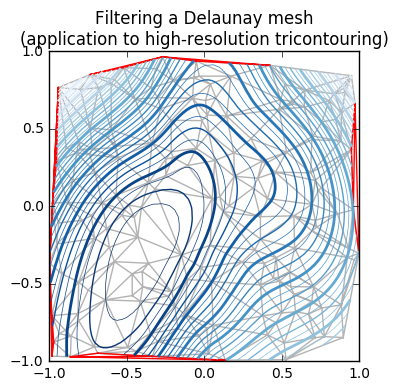

In [26]:
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner



#-----------------------------------------------------------------------------
# 用于测试的函数
#-----------------------------------------------------------------------------
def experiment_res(x, y):
    """ 表实验结果的分析函数"""
    x = 2.*x
    r1 = np.sqrt((0.5 - x)**2 + (0.5 - y)**2)
    theta1 = np.arctan2(0.5 - x, 0.5 - y)
    r2 = np.sqrt((-x - 0.2)**2 + (-y - 0.2)**2)
    theta2 = np.arctan2(-x - 0.2, -y - 0.2)
    z = (4*(np.exp((r1/10)**2) - 1)*30. * np.cos(3*theta1) +
         (np.exp((r2/10)**2) - 1)*30. * np.cos(5*theta2) +
         2*(x**2 + y**2))
    return (np.max(z) - z)/(np.max(z) - np.min(z))

#-----------------------------------------------------------------------------
# 生成初始数据测试点和演示的三角测量
#-----------------------------------------------------------------------------

n_test = 200  # 测试数据点数，对于subdiv = 3从3到5000进行测试

subdiv = 3  # 平滑图的初始网格的递归细分数。 
            #值> 3可能导致精细网格的三角形数量非常多：new triangles numbering =（4 ** subdiv）* ntri

init_mask_frac = 0.0    

min_circle_ratio = .01  

# 随机点
random_gen = np.random.mtrand.RandomState(seed=127260)
x_test = random_gen.uniform(-1., 1., size=n_test)
y_test = random_gen.uniform(-1., 1., size=n_test)
z_test = experiment_res(x_test, y_test)

# 使用Delaunay三角网格划分
tri = Triangulation(x_test, y_test)
ntri = tri.triangles.shape[0]

# 剔除一些要屏蔽的点
mask_init = np.zeros(ntri, dtype=np.bool)
masked_tri = random_gen.randint(0, ntri, int(ntri*init_mask_frac))
mask_init[masked_tri] = True
tri.set_mask(mask_init)


#-----------------------------------------------------------------------------
# 在高分辨率绘图之前改进三角测量：删除平面三角形
#-----------------------------------------------------------------------------
# 掩蔽在三角形网格的边界处的不良形状的三角形
mask = TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio)
tri.set_mask(mask)

# 精细化数据
refiner = UniformTriRefiner(tri)
tri_refi, z_test_refi = refiner.refine_field(z_test, subdiv=subdiv)

# 用于与分析进行比较
z_expected = experiment_res(tri_refi.x, tri_refi.y)


flat_tri = Triangulation(x_test, y_test)
flat_tri.set_mask(~mask)

#开始画图
plot_tri = True          # plot of base triangulation
plot_masked_tri = True   # plot of excessively flat excluded triangles
plot_refi_tri = False    # plot of refined triangulation
plot_expected = False    # plot of analytical function values for comparison


# Graphical options for tricontouring
levels = np.arange(0., 1., 0.025)
cmap = cm.get_cmap(name='Blues', lut=None)

plt.figure()
plt.gca().set_aspect('equal')
plt.title("Filtering a Delaunay mesh\n" +
          "(application to high-resolution tricontouring)")

# 1) 精确（计算）数据轮廓的图：
plt.tricontour(tri_refi, z_test_refi, levels=levels, cmap=cmap,
               linewidths=[2.0, 0.5, 1.0, 0.5])
# 2) 预期（分析）数据轮廓（虚线）的图：
if plot_expected:
    plt.tricontour(tri_refi, z_expected, levels=levels, cmap=cmap,
                   linestyles='--')
# 3) 进行内插的细网格的图：
if plot_refi_tri:
    plt.triplot(tri_refi, color='0.97')
# 4) 初始“粗糙”网格的图：
if plot_tri:
    plt.triplot(tri, color='0.7')
# 4) 从原生的Delaunay三角形而来的未经验证的三角形的图：
if plot_masked_tri:
    plt.triplot(flat_tri, color='red')

plt.show()


+ scale_factors

将三角划分为以平方为单位。